### The Cliff

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
%matplotlib inline

### Parameters

In [2]:
# Parameters 
nrow = 4
ncol = 12
epsilon = 0.1
gamma = 0.9
alpha = 0.5
# right, left, down, up
actions = [(0,1), (0,-1), (1,0), (-1,0)]
sStart = (3,0)
sGoal = (3,ncol-1)
rSumQ,rSumSarsa,rSumESarsa = [],[],[]
n_iter = 10000

In [18]:
option = 'expected_sarsa'

### Board Setup 

In [19]:
# Board setup 
board = np.empty((nrow,ncol), dtype = "U1")
for i in range(nrow): 
    for j in range(ncol): 
        if i == sStart[0]: 
            if j == sStart[1]:      board[i,j] = 'S'  # start
            elif j == sGoal[1]:     board[i,j] = 'G'  # goal
            else:                    board[i,j] = 'C'  # THE CLIFF 
        else:                        board[i,j] = '.'  # everything else 

### Initialise q and pi

In [20]:
q = np.random.uniform(size = (nrow, ncol, len(actions)))
q[nrow-1, ncol-1,:] = 0  # setting terminal state to 0 
pi = np.zeros(shape = (nrow, ncol, len(actions)))
# Find maximum values of q 
# If theres a tie, break randomly 
argmax_qs = [np.where(q[i,j,:] == np.amax(q, axis = 2)[i,j])[0].tolist()
 for i in range(nrow) for j in range(ncol)]
q_choices = list(map(lambda x: np.random.choice(x), argmax_qs))
argmax_qs = np.array(q_choices).reshape(nrow,ncol)
# Initialise pi 
for i in range(nrow):
    for j in range(ncol):
        for a in range(len(actions)):
            if a == argmax_qs[i,j]:  pi[i,j,a] = 1 - (len(actions)-1)*epsilon/len(actions)
            else:                    pi[i,j,a] =                      epsilon/len(actions)

### Sim episode - q learning 

In [21]:
# sP = s prime 
for i in range(n_iter): 
    if i %1000 == 0 : print(i)
    s = sStart
    rSum = 0
    while board[s] != 'G':
        #print(s,a,sP,r,q[s[0], s[1], a_idx],q[sP[0], sP[1], aP] )
        # Adjust pi 
        max_qs = np.where(q[s[0],s[1],:] == max(q[s[0],s[1],:]))[0].tolist()
        max_a = np.random.choice(max_qs)
        for j in range(len(actions)):
                if j == max_a:  pi[s[0],s[1],j] = 1 - (len(actions)-1)*epsilon/len(actions)
                else:           pi[s[0],s[1],j] =                      epsilon/len(actions)
        #sim action
        a_idx = np.argmax(np.random.uniform() < np.cumsum(pi[s[0],s[1],:]))
        a = actions[a_idx]
        sP = tuple(np.add(s, a))
        # sation adjustment for going off side of board 
        if sP[0] < 0: sP = (0, sP[1])
        if sP[1] < 0: sP = (sP[0], 0)
        if sP[0] >= nrow : sP = (nrow - 1, sP[1])
        if sP[1] >= ncol : sP = (sP[0], ncol - 1)
        # get reward, deal with cliff
        if board[sP] == 'C':   r = -100; sP = sStart
        else:                  r = -1
        if option == 'q_learning': 
            # get max_a' q(s', a') and break ties randomly
            q_max_choices = np.where(q[sP[0], sP[1],:] == 
                                 max(q[sP[0], sP[1],:]))[0].tolist()
            aP_idx = np.random.choice(q_max_choices)  
            # q_update
            q[s[0], s[1], a_idx] += alpha * (r + gamma *  q[sP[0], sP[1], aP_idx] 
                                             - q[s[0], s[1], a_idx])
        elif option == 'sarsa': 
            # pick according to policy 
            aP_idx = np.argmax(np.random.uniform() < np.cumsum(pi[sP[0],sP[1],:]))
            q[s[0], s[1], a_idx] += alpha * (r + gamma *  q[sP[0], sP[1], aP_idx] 
                                             - q[s[0], s[1], a_idx])
        elif option == 'expected_sarsa': 
            qExpec = sum((pi[sP[0], sP[1], a_idx] * q[sP[0], sP[1], a_idx] 
                                                    for a_idx in range(len(actions))))
            q[s[0], s[1], a_idx] += alpha * (r + gamma *  qExpec 
                                             - q[s[0], s[1], a_idx])
        s = sP
        rSum += r
        
    if option == 'q_learning':      rSumQ.append(rSum)
    elif option == 'sarsa':          rSumSarsa.append(rSum)
    elif option == 'expected_sarsa': rSumESarsa.append(rSum)
    else: print("INVALID OPTION")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [22]:
v = np.max(q, axis = 2)

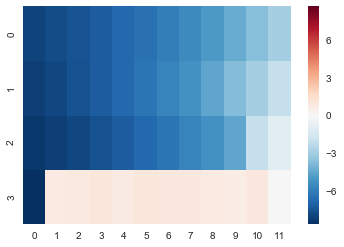

In [23]:
sns.heatmap(v)

In [24]:
# policy 
np.argmax(q,axis=2)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2],
       [3, 2, 2, 1, 3, 0, 2, 3, 2, 1, 2, 0]])

In [25]:
rSumQ

[-1563,
 -431,
 -711,
 -191,
 -154,
 -98,
 -80,
 -178,
 -61,
 -24,
 -286,
 -50,
 -170,
 -28,
 -172,
 -47,
 -54,
 -31,
 -135,
 -79,
 -30,
 -26,
 -140,
 -23,
 -38,
 -153,
 -22,
 -26,
 -34,
 -19,
 -34,
 -33,
 -27,
 -140,
 -18,
 -36,
 -27,
 -140,
 -15,
 -21,
 -18,
 -576,
 -15,
 -29,
 -18,
 -241,
 -14,
 -19,
 -19,
 -21,
 -13,
 -17,
 -13,
 -17,
 -26,
 -13,
 -13,
 -13,
 -13,
 -13,
 -129,
 -15,
 -13,
 -126,
 -13,
 -14,
 -21,
 -13,
 -17,
 -13,
 -13,
 -15,
 -17,
 -17,
 -15,
 -117,
 -13,
 -30,
 -21,
 -15,
 -17,
 -13,
 -17,
 -13,
 -13,
 -121,
 -543,
 -13,
 -13,
 -13,
 -13,
 -14,
 -15,
 -13,
 -120,
 -118,
 -15,
 -16,
 -13,
 -126,
 -122,
 -13,
 -116,
 -14,
 -13,
 -13,
 -15,
 -21,
 -13,
 -15,
 -121,
 -14,
 -13,
 -13,
 -223,
 -236,
 -119,
 -123,
 -13,
 -124,
 -13,
 -126,
 -15,
 -14,
 -15,
 -13,
 -13,
 -226,
 -13,
 -115,
 -13,
 -17,
 -17,
 -13,
 -15,
 -15,
 -223,
 -15,
 -14,
 -13,
 -15,
 -13,
 -117,
 -22,
 -15,
 -14,
 -13,
 -115,
 -118,
 -13,
 -15,
 -13,
 -15,
 -13,
 -19,
 -246,
 -13,
 -20,
 -15,
 -16,

In [26]:
rSumSarsa

[-1894,
 -281,
 -128,
 -107,
 -46,
 -55,
 -100,
 -94,
 -60,
 -43,
 -52,
 -50,
 -196,
 -46,
 -53,
 -37,
 -29,
 -31,
 -81,
 -39,
 -46,
 -71,
 -180,
 -136,
 -26,
 -44,
 -28,
 -26,
 -20,
 -20,
 -36,
 -21,
 -21,
 -20,
 -22,
 -19,
 -18,
 -20,
 -17,
 -19,
 -22,
 -19,
 -19,
 -17,
 -21,
 -19,
 -17,
 -23,
 -17,
 -17,
 -19,
 -19,
 -17,
 -18,
 -18,
 -20,
 -20,
 -19,
 -18,
 -20,
 -19,
 -120,
 -17,
 -19,
 -17,
 -23,
 -19,
 -21,
 -22,
 -17,
 -24,
 -17,
 -20,
 -17,
 -21,
 -26,
 -18,
 -21,
 -23,
 -17,
 -17,
 -17,
 -18,
 -22,
 -17,
 -19,
 -21,
 -18,
 -17,
 -17,
 -17,
 -21,
 -19,
 -18,
 -23,
 -20,
 -19,
 -20,
 -23,
 -19,
 -19,
 -19,
 -17,
 -17,
 -18,
 -17,
 -17,
 -140,
 -17,
 -17,
 -23,
 -17,
 -18,
 -21,
 -17,
 -22,
 -22,
 -17,
 -20,
 -18,
 -20,
 -23,
 -25,
 -118,
 -19,
 -17,
 -19,
 -20,
 -19,
 -20,
 -17,
 -17,
 -25,
 -20,
 -17,
 -19,
 -24,
 -20,
 -21,
 -25,
 -19,
 -18,
 -21,
 -17,
 -19,
 -22,
 -19,
 -18,
 -19,
 -18,
 -124,
 -24,
 -18,
 -119,
 -17,
 -19,
 -23,
 -23,
 -20,
 -18,
 -17,
 -18,
 -19,
 -21,
 -

In [27]:
rSumESarsa

[-1126,
 -490,
 -604,
 -241,
 -80,
 -108,
 -42,
 -103,
 -321,
 -78,
 -36,
 -54,
 -41,
 -26,
 -31,
 -43,
 -25,
 -33,
 -23,
 -28,
 -39,
 -20,
 -31,
 -27,
 -31,
 -19,
 -19,
 -19,
 -20,
 -32,
 -30,
 -20,
 -20,
 -119,
 -19,
 -19,
 -21,
 -21,
 -122,
 -19,
 -17,
 -18,
 -19,
 -17,
 -18,
 -20,
 -18,
 -19,
 -24,
 -17,
 -17,
 -18,
 -23,
 -19,
 -20,
 -19,
 -21,
 -18,
 -18,
 -19,
 -18,
 -23,
 -17,
 -19,
 -19,
 -140,
 -19,
 -17,
 -17,
 -17,
 -17,
 -17,
 -19,
 -18,
 -17,
 -17,
 -17,
 -17,
 -19,
 -17,
 -18,
 -21,
 -17,
 -21,
 -21,
 -19,
 -24,
 -21,
 -22,
 -21,
 -17,
 -132,
 -17,
 -19,
 -18,
 -17,
 -26,
 -19,
 -19,
 -21,
 -17,
 -22,
 -17,
 -19,
 -19,
 -18,
 -18,
 -17,
 -21,
 -20,
 -18,
 -21,
 -19,
 -21,
 -20,
 -20,
 -19,
 -19,
 -23,
 -17,
 -17,
 -24,
 -120,
 -19,
 -17,
 -23,
 -21,
 -19,
 -19,
 -18,
 -21,
 -19,
 -17,
 -17,
 -17,
 -17,
 -21,
 -19,
 -25,
 -18,
 -23,
 -19,
 -20,
 -18,
 -17,
 -19,
 -20,
 -21,
 -19,
 -17,
 -20,
 -17,
 -17,
 -17,
 -18,
 -17,
 -21,
 -20,
 -17,
 -19,
 -17,
 -17,
 -21,
 -19,
 -1

In [36]:
df = pd.DataFrame({'e_sarsa': rSumESarsa, 
             'q_learning':rSumQ ,
             'sarsa': rSumSarsa})

In [40]:
df.describe()

,e_sarsa,q_learning,sarsa
count,10000.000000,10000.000000,10000.000000
mean,-21.303400,-51.782600,-201.484600
std,23.704028,74.454002,2655.927423
min,-1126.000000,-1563.000000,-169487.000000
25%,-19.000000,-113.250000,-25.000000
50%,-17.000000,-15.000000,-20.000000
75%,-15.000000,-13.000000,-18.000000
max,-15.000000,-13.000000,-17.000000


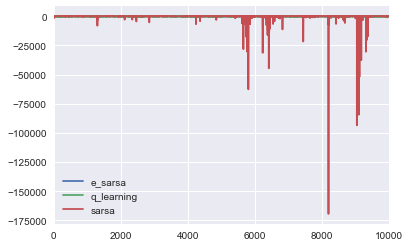

In [41]:
df.plot()